## Setup


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#!conda activate gnngeometry

In [3]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Generate Closed Helix

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import torch
from sklearn.neighbors import kneighbors_graph
import scipy as sc
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected

def generate_sphere(r=1, alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 2 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi =  math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  x = r * np.cos(theta) * np.sin(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(phi)
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

In [5]:
def generate_helix(alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 8 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi = 4 * math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  n =  np.random.uniform(0,1,n_samples)
  #x=(1.2+0.1*np.cos(phi))*np.cos(theta)
  #y=(1.2+0.1*np.cos(phi))*np.sin(theta)
  theta = np.sort(theta)
  x = n*np.cos(theta)
  y = n*np.sin(theta)
  #z=0.1*np.sin(phi)+theta/np.pi
  z = theta/np.pi 
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

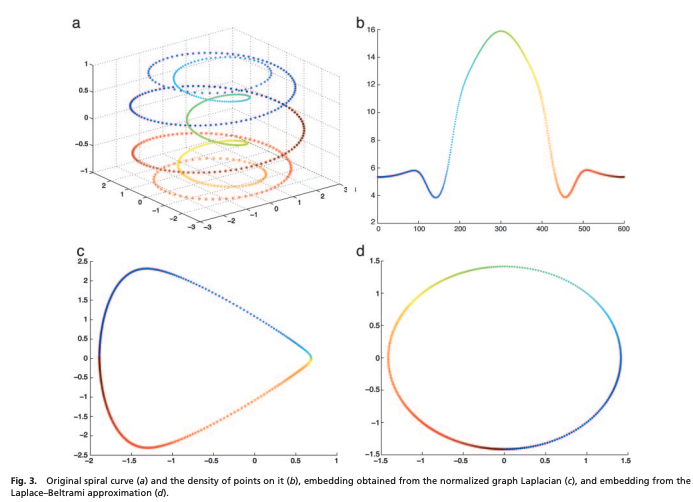

need to generate helix curve rather than spheres?

image.png

reference: https://github.com/goroda/diffusion_maps/blob/main/gendata.py

In [6]:
import argparse
import sys
import numpy as np

def get_vhelix(uniform=True, a = 0.5, b = 0.5, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
    # plot vertical helix
    # CANNOT REPRODUCE THE COIFMAN PAPER YET
    npts = n_samples
    if uniform is True:
        time = np.linspace(0, 1, npts);
    else:
        np.random.seed(seed)
        time = np.sort(np.random.beta(a, b, size=(npts)))


    height = np.sin(1.0 * np.pi * time)
    radius = np.sin(2.0 * 2.0 * np.pi * time) + 2.0
    x = radius * np.cos(5 * 2 * np.pi * time)
    y = radius * np.sin(5 * 2 * np.pi * time)

    X = np.vstack([np.array(x), np.array(y), np.array(height)]).T
    A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
    edge_index, edge_weights = from_scipy_sparse_matrix(A)
    edge_index, edge_weights = to_undirected(edge_index, edge_weights)
    if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
    if features == 'coordinates':
        new_data = Data(x=torch.from_numpy(X).float(),
                        edge_index=edge_index,
                        edge_weight=edge_weights)
    else:
        new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                        edge_weight=edge_weights)
    return x,y, height, time, A, new_data

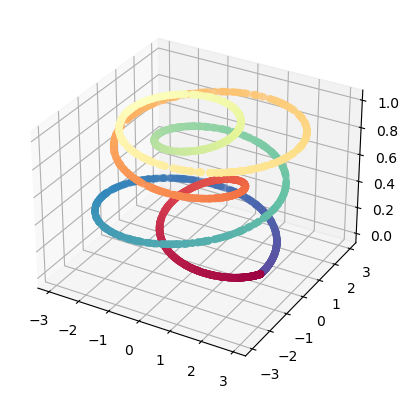

In [7]:
x,y,z,t,_,new_data = get_vhelix(uniform = False)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)

source: https://rdrr.io/github/kcf-jackson/maniTools/src/R/simulate_data.R

In [8]:
#' Toroidal Helix by Coifman & Lafon
#' @param N integer; Number of datapoints.
#' @param sample_rate numeric; Sampling rate.
#' @export
def toroidal_helix(N, sample_rate = 1.0):
  """
  input: number of samples
  output: data, color
  """
  noiseSigma = 0.05 #noise parameter
  t = np.arange(1,N+1) / N
  t = (t**(sample_rate)) * 2 * np.pi
  noise = noiseSigma * np.random.normal(size = (N,3))
  x =  (2+np.cos(8*t))*np.cos(t) + noiseSigma * np.random.normal(size = N)
  y =  (2+np.cos(8*t))*np.sin(t) + noiseSigma * np.random.normal(size = N) 
  z = np.sin(8*t) +  noiseSigma * np.random.normal(size = N)
  return x,y,z, t

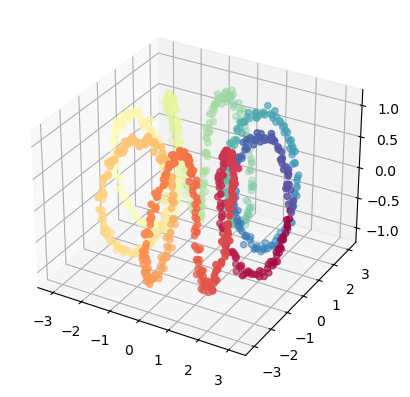

In [9]:
x,y,z,t = toroidal_helix(N= 1000, sample_rate = 1.0)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)

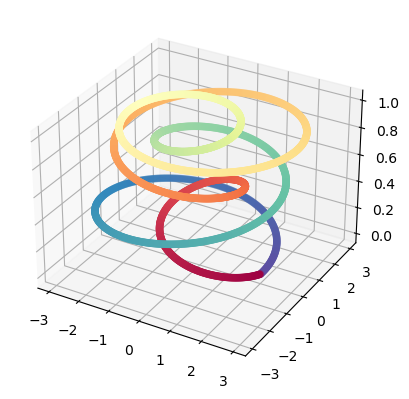

In [10]:
x,y,z,t, A,new_data = get_vhelix(uniform = True)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_51058/1736191027.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


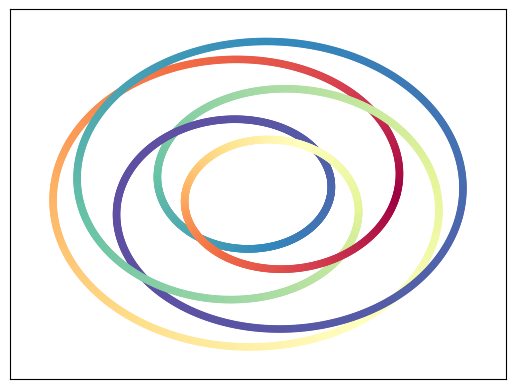

In [11]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral', with_labels=False, node_size = 20)
plt.show()

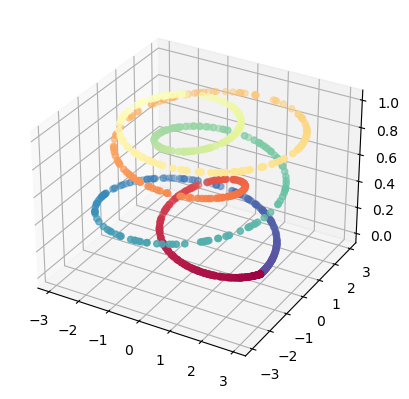

In [12]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 0.5, b = 0.5,n_samples = 1000)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_51058/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


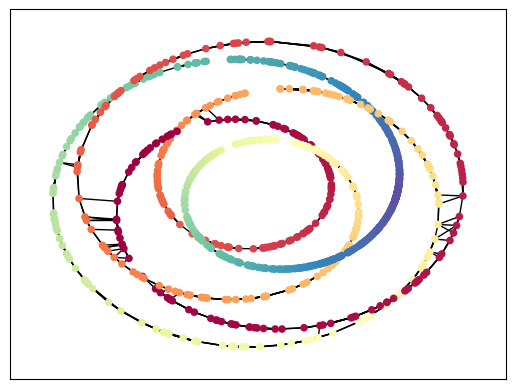

In [13]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

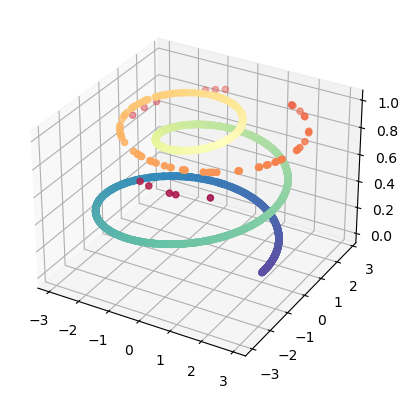

In [14]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 1, b = 5)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_51058/3349307350.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


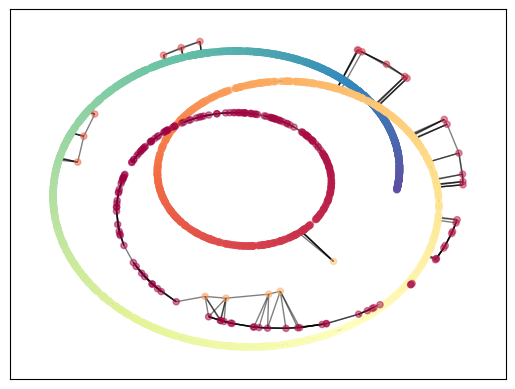

In [15]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20, alpha = 0.5)
plt.show()

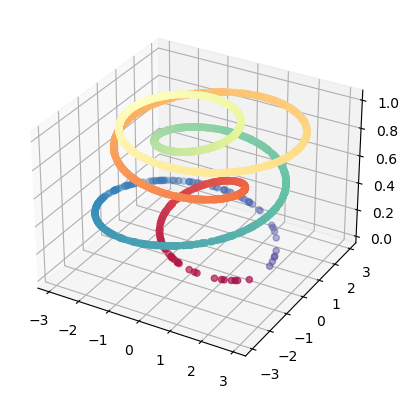

In [16]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 2, b = 2)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_51058/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


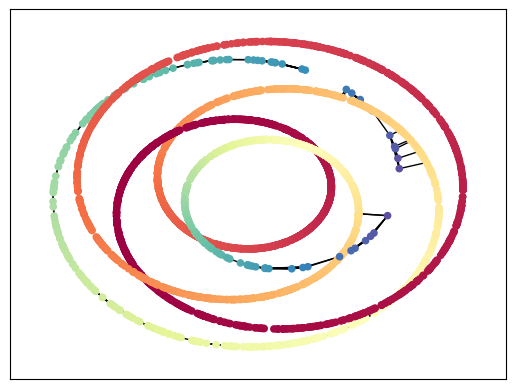

In [17]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

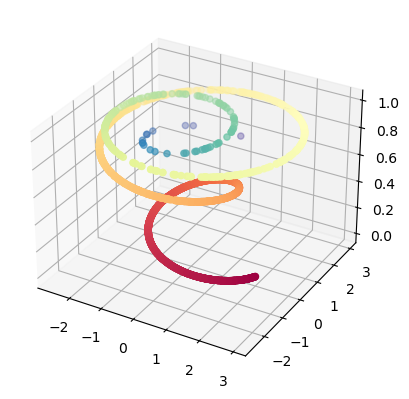

In [18]:
x,y,z,t, A,new_data = get_vhelix(uniform = False, a = 5, b = 1)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_51058/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


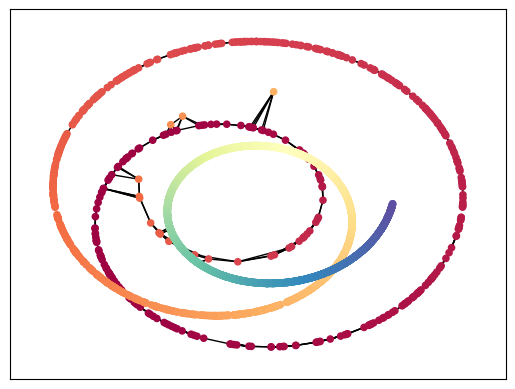

In [19]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

In [20]:
cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry

/Users/sowonjeong/Documents/GitHub/GNN-Geometry


In [21]:
from models.dgi import *
from models.train_models import train_dgi
from models.baseline_models import *

In [22]:
cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook

/Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook


## Embeddings across $\alpha$

In [23]:
x,y,z,t,_,dataset = get_vhelix(uniform = False, a = 0.5, b = 0.5, n_samples = 1500)

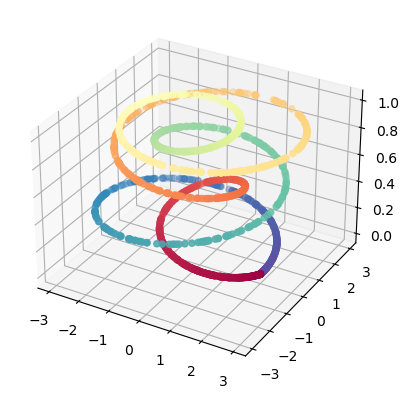

In [24]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = t)
#ax.plot(x,y,z)
plt.show()

In [25]:
from scipy.special import beta, gamma
from numpy import linspace, exp
def beta_density_plot(a=1, b =1, n_samples = 500):
    x = linspace(.01, .99, n_samples)
    a = a
    b = b
    y = (1 / beta(a, b)) * x ** (a - 1) * (1 - x) ** (b - 1)
    # plt.figure(figsize = (12,8))
    plt.scatter(x,y, cmap = plt.cm.Spectral_r, c = x, s = 10)
    plt.show()

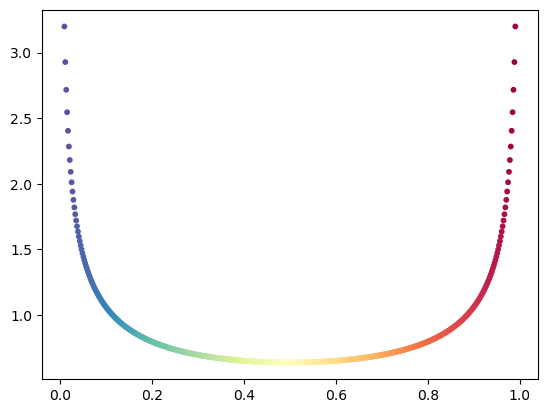

In [26]:
beta_density_plot(a=0.5, b = 0.5)

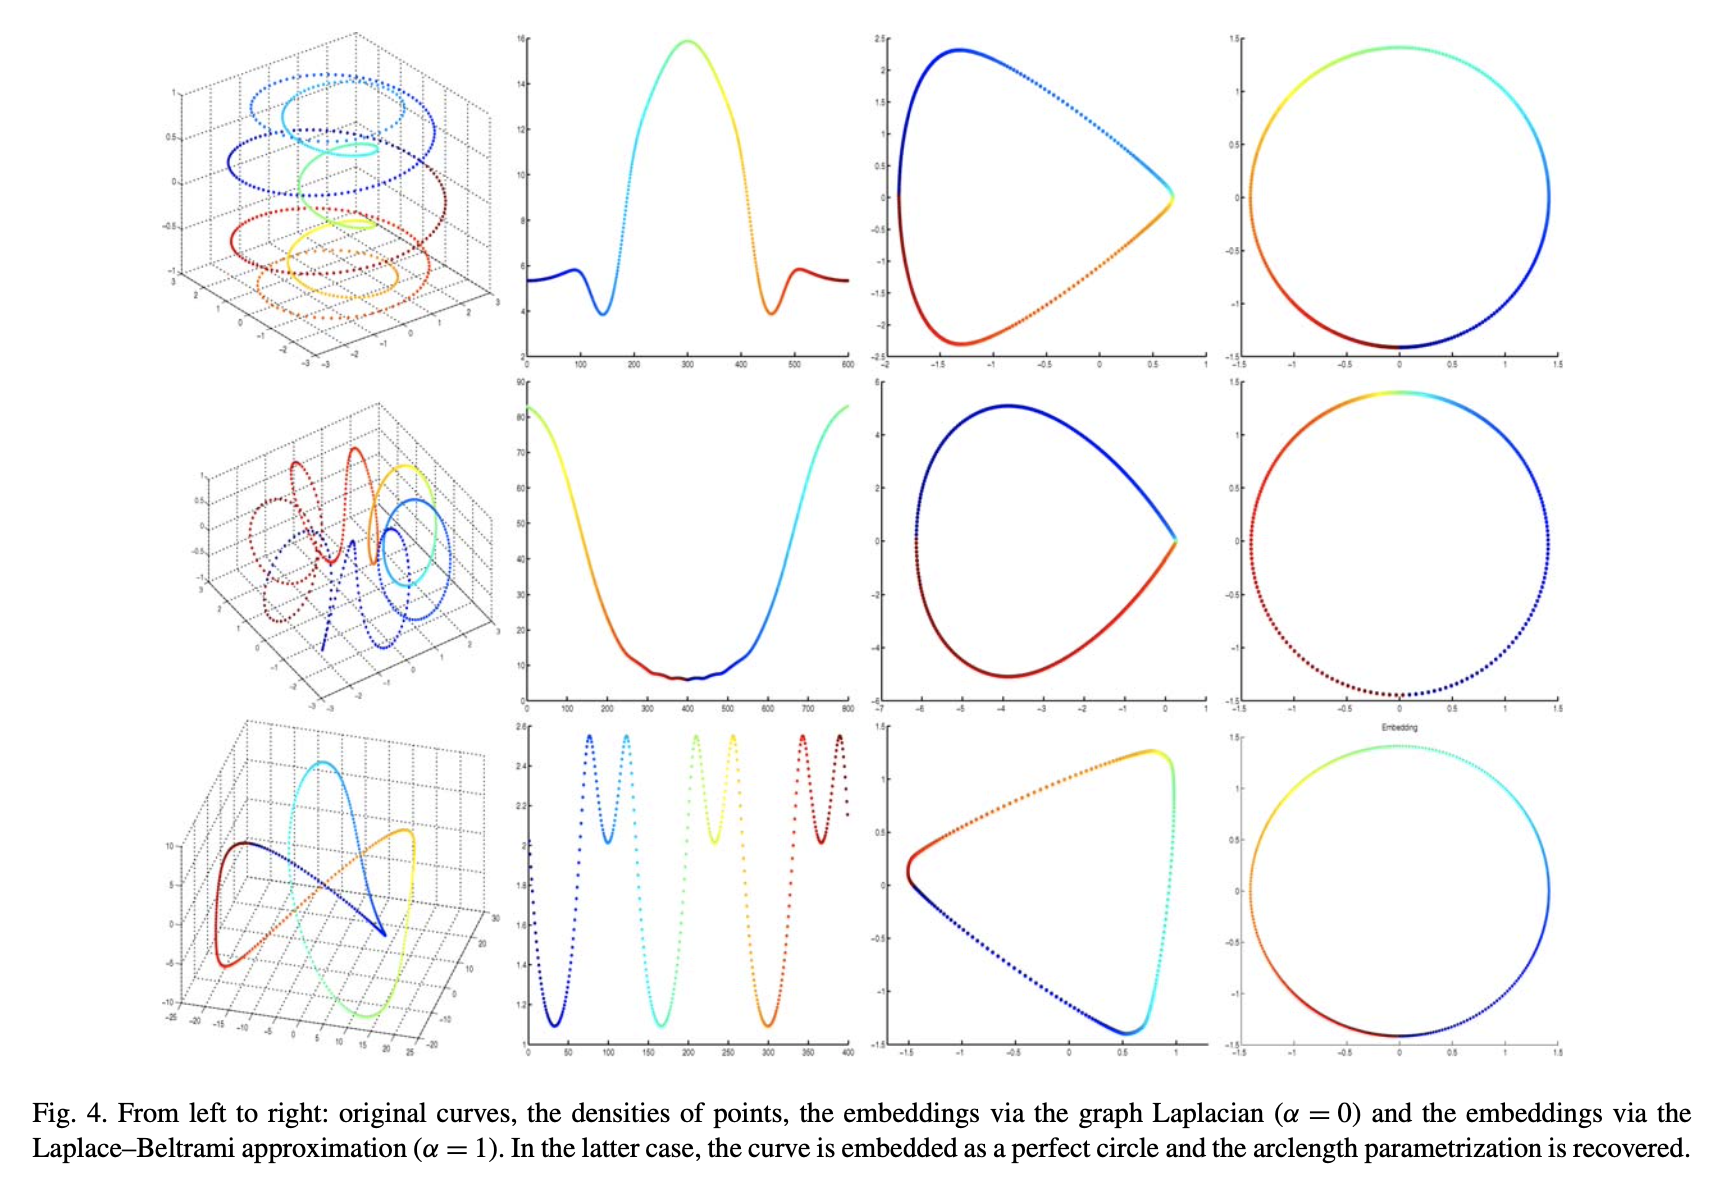

In [27]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_dgi(dataset,hid_dim = 32, out_dim = 2, n_layers = 2, patience=50,
              epochs=500, lr=1e-2, name_file="1", device=None, alpha = alpha[i], beta = 1, add_self_loops = True, dropout_rate = 0.01)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp

=== train DGI model ===
Epoch=000, loss=1.0716, time=0.0955
Epoch=001, loss=0.7456, time=0.0123
Epoch=002, loss=0.7238, time=0.0121
Epoch=003, loss=0.6944, time=0.0126
Epoch=004, loss=0.6757, time=0.0128
Epoch=005, loss=0.6822, time=0.0127
Epoch=006, loss=0.6867, time=0.0124
Epoch=007, loss=0.6886, time=0.0098
Epoch=008, loss=0.6897, time=0.0125
Epoch=009, loss=0.6906, time=0.0136
Epoch=010, loss=0.6905, time=0.0159
Epoch=011, loss=0.6903, time=0.0156
Epoch=012, loss=0.6925, time=0.0134
Epoch=013, loss=0.6898, time=0.0139
Epoch=014, loss=0.6907, time=0.0112
Epoch=015, loss=0.6896, time=0.0110
Epoch=016, loss=0.6930, time=0.0114
Epoch=017, loss=0.6896, time=0.0117
Epoch=018, loss=0.6915, time=0.0114
Epoch=019, loss=0.6903, time=0.0124
Epoch=020, loss=0.6908, time=0.0113
Epoch=021, loss=0.6908, time=0.0105
Epoch=022, loss=0.6917, time=0.0123
Epoch=023, loss=0.6899, time=0.0110
Epoch=024, loss=0.6869, time=0.0110
Epoch=025, loss=0.6875, time=0.0121
Epoch=026, loss=0.6863, time=0.0144
Epoc

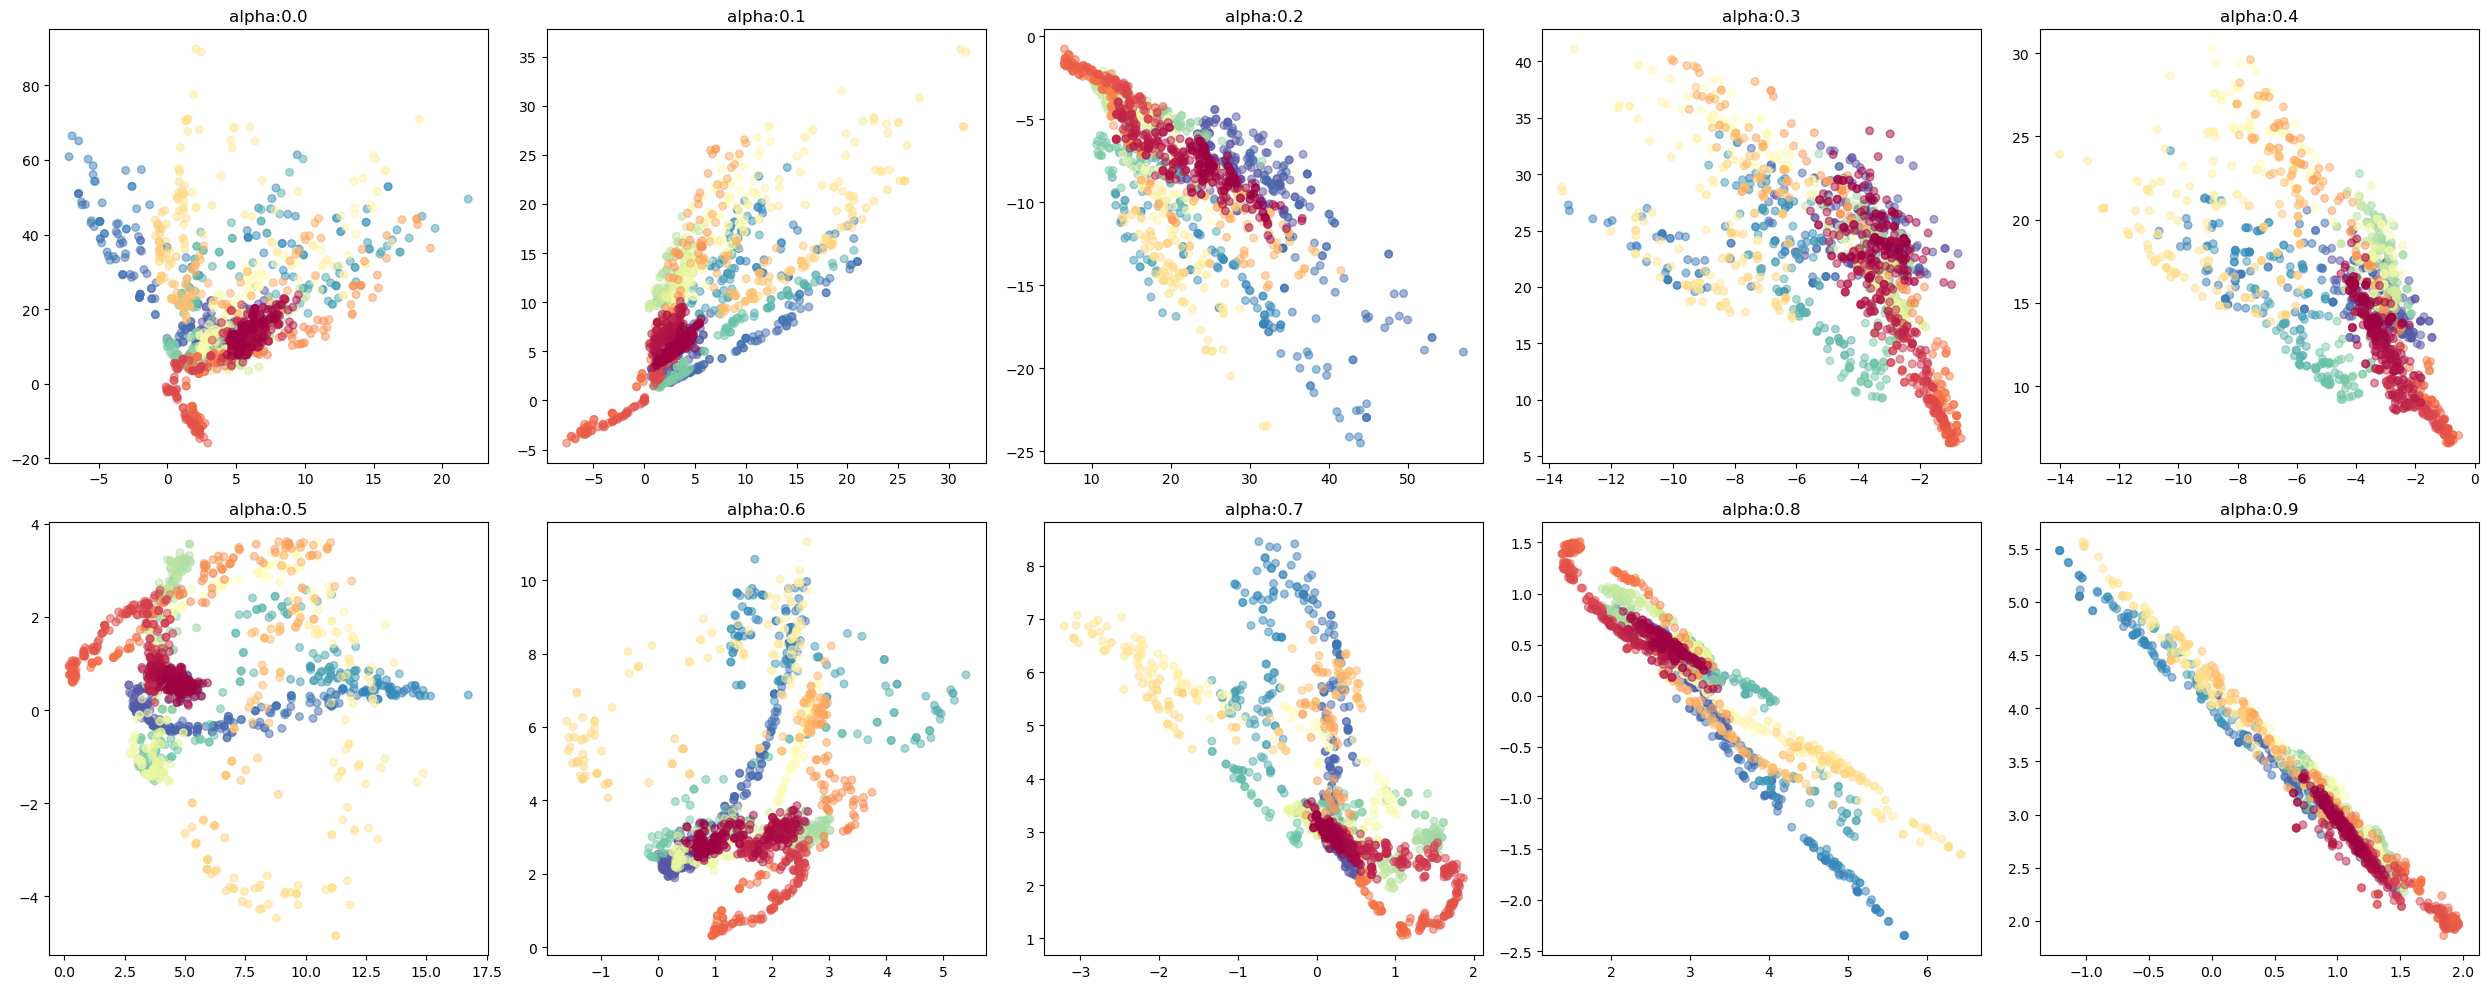

In [78]:
# dropout = 0.01
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

In [79]:
from models.grace import *
from models.train_models import train_grace
from models.baseline_models import *

In [82]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_grace(dataset, 32, 2, n_layers=1, tau=0.5,
                epochs=500, wd=1e-3, lr=1e-1, fmr=0.2, edr =0.5,
                proj="nonlinear-hid", name_file="test", device=None,
                gnn_type="RW", alpha=alpha[i], beta = 1,add_self_loops= True)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp


=== train GRACE model ===
Epoch=000, loss=7.9634
Epoch=001, loss=8.0281
Epoch=002, loss=7.9370
Epoch=003, loss=7.8535
Epoch=004, loss=8.0025
Epoch=005, loss=7.6765
Epoch=006, loss=8.0242
Epoch=007, loss=7.5437
Epoch=008, loss=7.6860
Epoch=009, loss=7.6050
Epoch=010, loss=7.3593
Epoch=011, loss=7.3532
Epoch=012, loss=7.2578
Epoch=013, loss=7.3334
Epoch=014, loss=7.7173
Epoch=015, loss=7.2681
Epoch=016, loss=7.7378
Epoch=017, loss=7.2492
Epoch=018, loss=8.7153
Epoch=019, loss=8.8791
Epoch=020, loss=8.3334
Epoch=021, loss=8.2051
Epoch=022, loss=7.3391
Epoch=023, loss=7.4967
Epoch=024, loss=7.4030
Epoch=025, loss=7.4259
Epoch=026, loss=7.4355
Epoch=027, loss=8.0421
Epoch=028, loss=8.0320
Epoch=029, loss=7.4515
Epoch=030, loss=8.0086
Epoch=031, loss=7.5709
Epoch=032, loss=7.4483
Epoch=033, loss=7.4371
Epoch=034, loss=7.5525
Epoch=035, loss=7.3860
Epoch=036, loss=8.0475
Epoch=037, loss=7.3461
Epoch=038, loss=7.5401
Epoch=039, loss=7.3195
Epoch=040, loss=7.3059
Epoch=041, loss=7.2918
Epoch=04

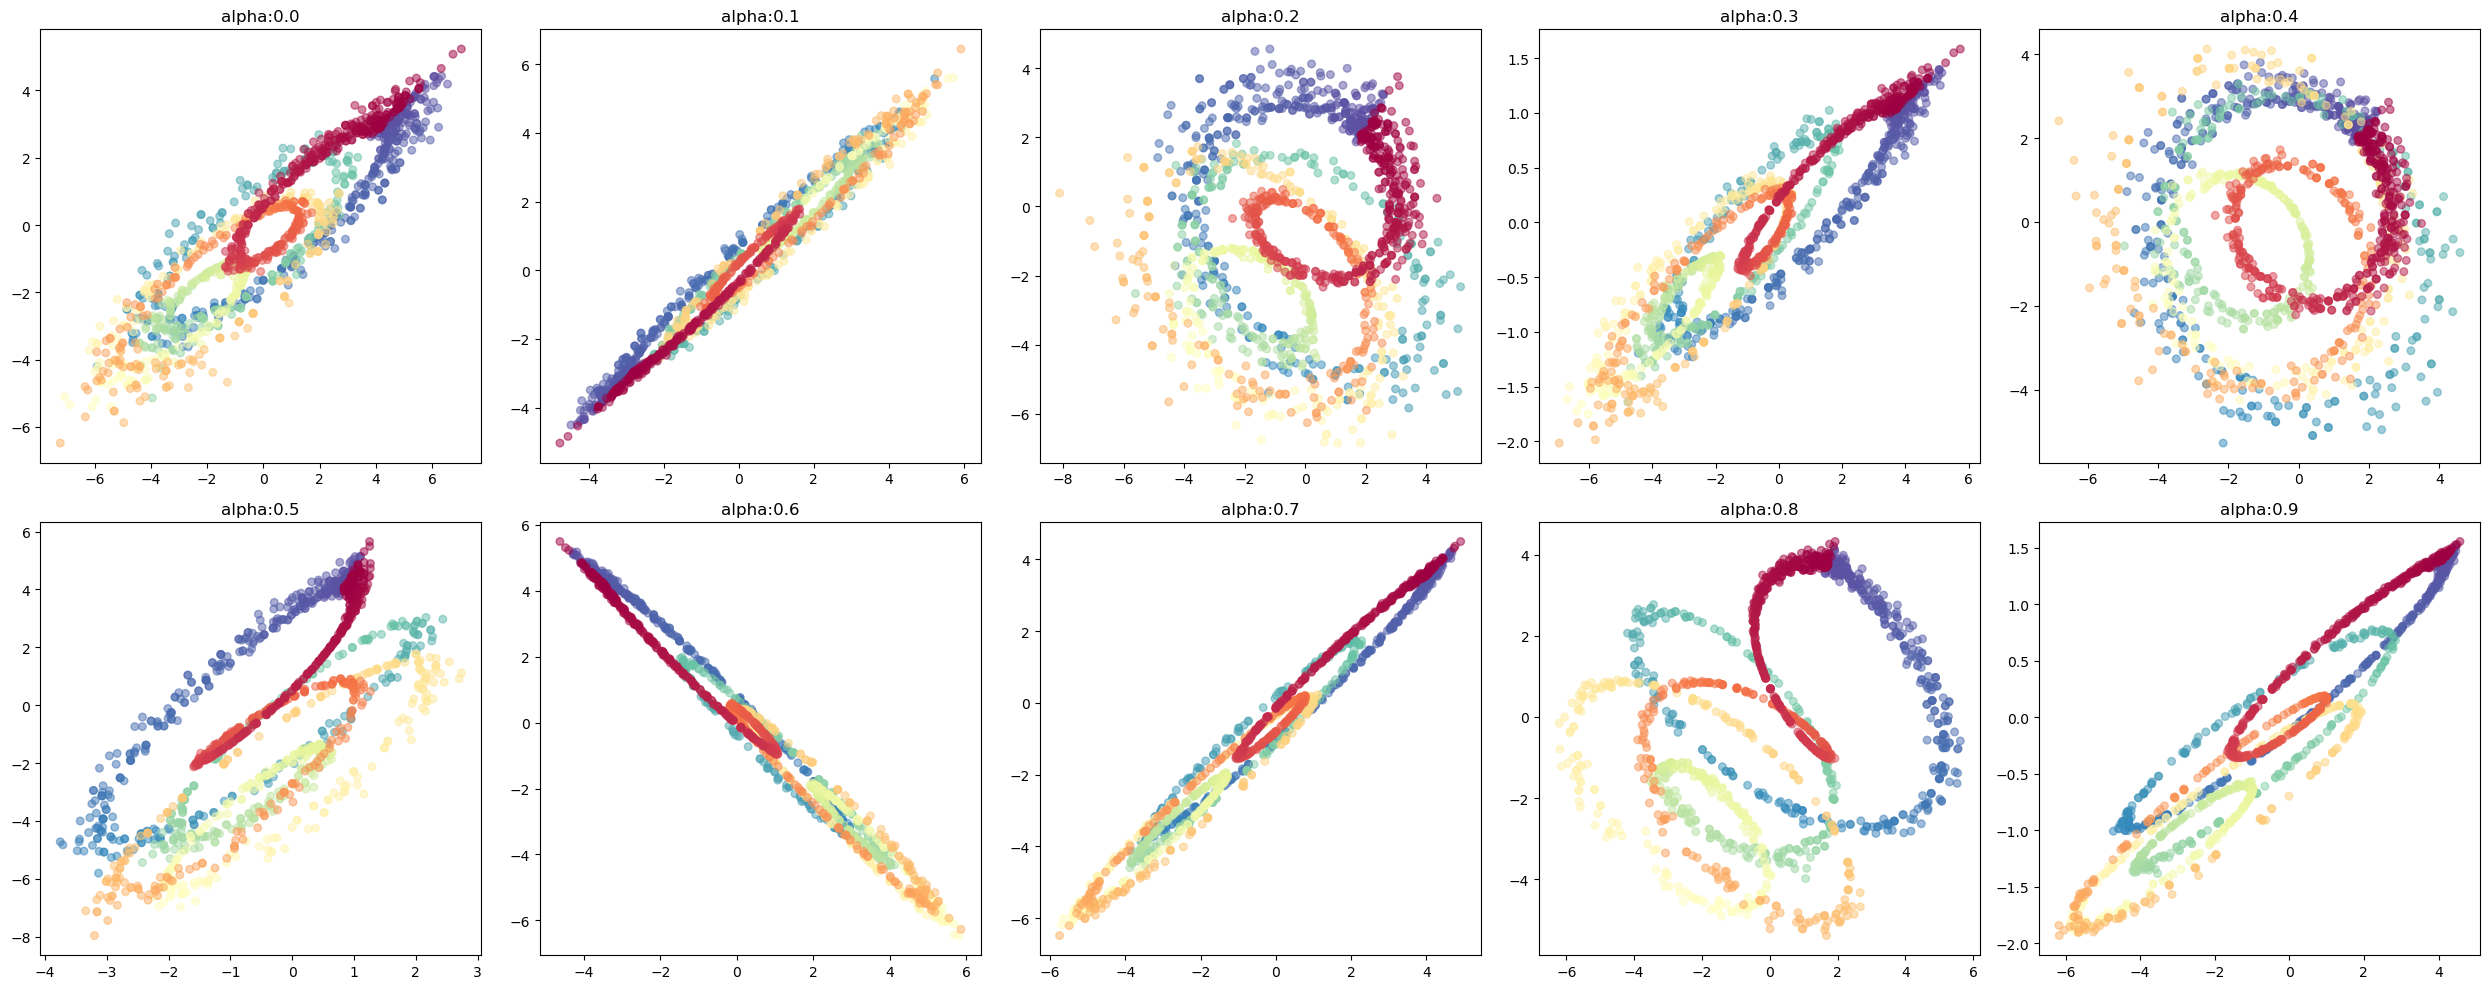

In [84]:
# row-normalized
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

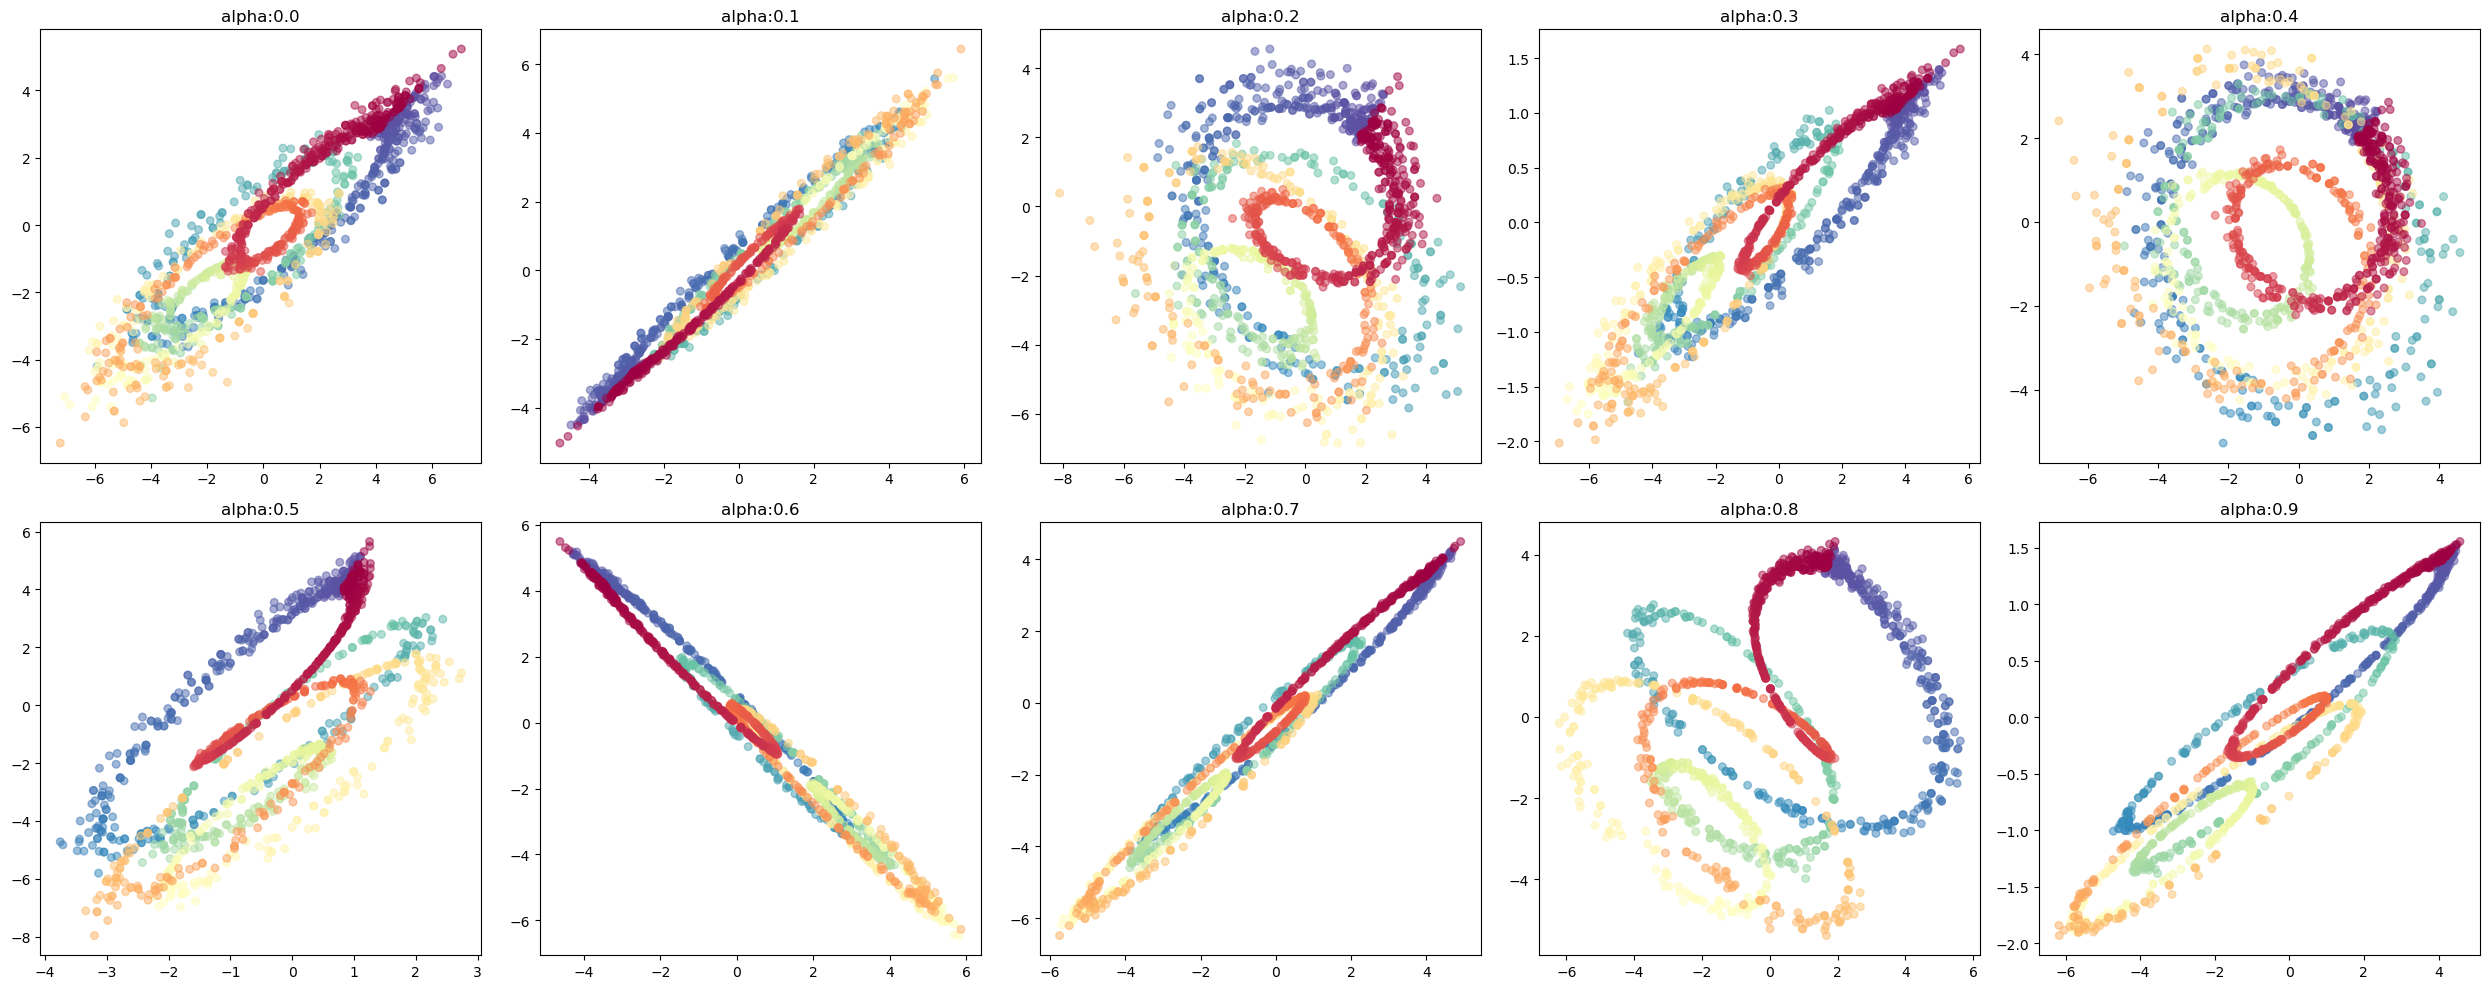

In [83]:
# symmetric
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = t, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

In [ ]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_dgi(dataset,hid_dim = 32, out_dim = 2, n_layers = 2, patience=50,
              epochs=500, lr=1e-2, name_file="1", device=None, alpha = alpha[i], beta = 1, add_self_loops = True, dropout_rate = 0.01)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp